#  TimeVAE: A Flexible VAE for Time Series Generation 

On this notebook, we’ll get hands-on with using **TimeVAE** model to tackle a generation task. Along the way, you’ll see how the model is built and trained on a specific dataset, and pick up the key ideas so that you can apply them to your own projects with your own data

## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import pandas as pd
from lightning import seed_everything
import torch
from datasets import load_dataset
from genai4t.utils import set_random_state, get_torch_device
from genai4t.data.processing import (
    split_timeseries_with_length,
    dataset_to_pandas
)
from sklearn.model_selection import train_test_split
from genai4t.plot_style import plot_style

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [2]:
ENV_CONFIG = {
        'random_state': 2024,
        'use_cuda': True
    }

DATA_CONFIG = {
        'name':  "gatam4t/genai4t_spx_generation",
        'batch_size': 16,
        'sequence_len': 20,
        "num_eval_iterations": 50,
    }

In [3]:
set_random_state(ENV_CONFIG["random_state"])
device = get_torch_device()

Seed set to 2024


## Load Data

In this experiment, we use time series data derived from the **S&P 500 Index (SPX)**, a benchmark index that tracks the performance of 500 of the largest publicly traded companies in the United States. Specifically, the dataset contains two time series:

•⁠  ⁠The log return of the closing price
•⁠  ⁠The log of the Median Realized Volatility

These values span the period from 2005-01-01 to 2020-06-01, and have been standardized to have a mean of 0 and a standard deviation of 1.

The data originates from the [Oxford-Man Realized Volatility Indices dataset](https://github.com/onnokleen/mfGARCH/raw/v0.1.9/data-raw/OxfordManRealizedVolatilityIndices.zip), published by the Oxford-Man Institute of Quantitative Finance (University of Oxford) in collaboration with Man Group, a global active investment management firm. This dataset is widely used in academic research and provides daily realized volatility measures computed from high-frequency intraday financial data.

To make access easier and ensure long-term reproducibility, a copy of the dataset processed has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

While we use this dataset for generation notebooks, the methods in this notebook work with any dataset in wide time series format (i.e., one time series per column) with minimal adjustments.

In [4]:
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
data = dataset_to_pandas(dataset)

# Display the first few rows of the DataFrame
data.head()

,logreturn,logvol
0,-0.979992,0.212416
1,-0.335923,0.438473
2,0.244094,-0.069770
3,-0.132698,0.087008
4,0.257988,-0.278999


In [5]:
# the data have been standardized
data.describe().T

,count,mean,std,min,25%,50%,75%,max
logreturn,3394.0,-3.371860e-09,1.0,-8.298640,-0.356489,0.033435,0.429621,9.072744
logvol,3394.0,-5.934473e-07,1.0,-2.290916,-0.676626,-0.136567,0.602935,4.178672


In [6]:
# transform dataframe into a numpy array
data_as_array = data.to_numpy().astype(np.float32)

In [7]:
data_as_array

array([[-0.979992  ,  0.21241626],
       [-0.33592334,  0.43847257],
       [ 0.24409448, -0.06976987],
       ...,
       [-1.195638  ,  1.0179971 ],
       [ 0.1652753 ,  0.08472553],
       [-0.74991983,  0.80158144]], dtype=float32)

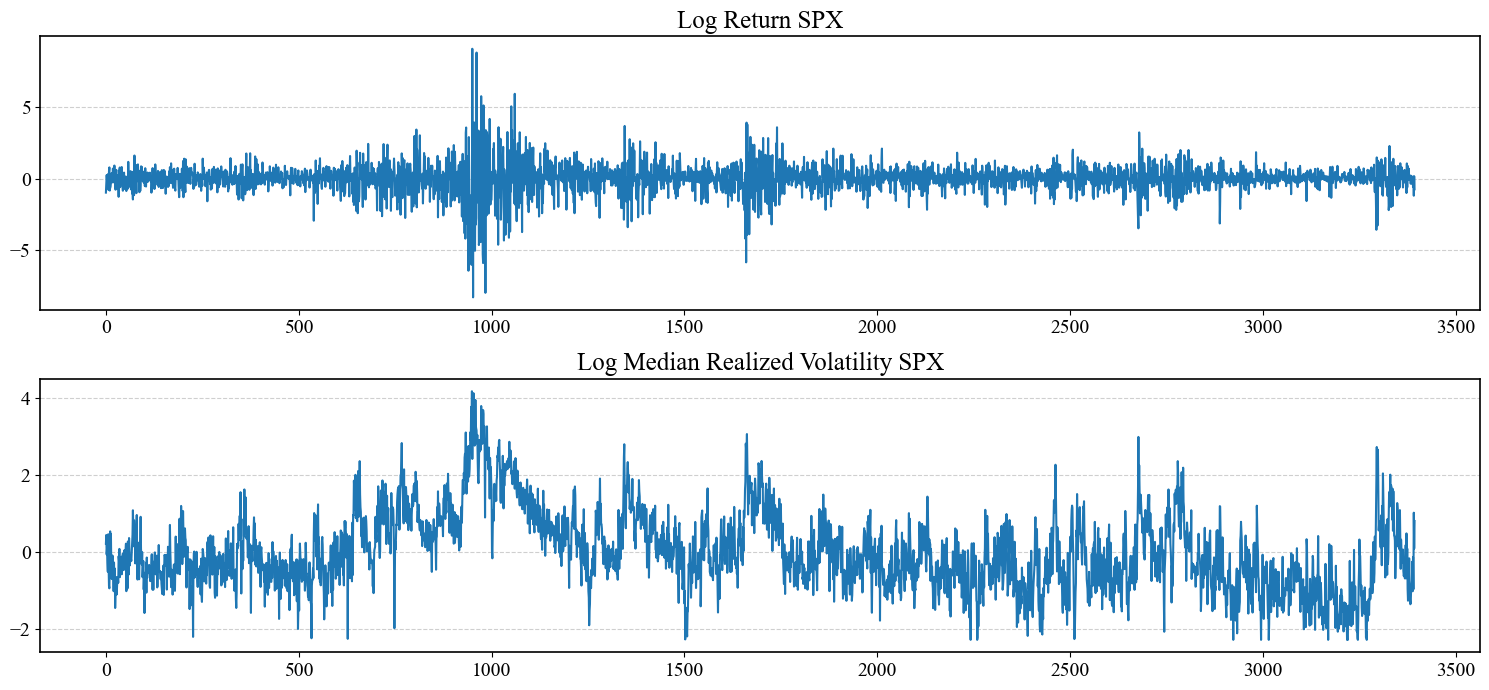

In [8]:
f, axs = plt.subplots(2, 1, figsize=(15, 7))
axs[0].plot(data_as_array[:, 0])
axs[0].set_title("Log Return SPX")
plot_style.apply_plot_style(axs[0])
plot_style.apply_grid(axs[0])
axs[1].plot(data_as_array[:, 1])
axs[1].set_title("Log Median Realized Volatility SPX")
plot_style.apply_plot_style(axs[1])
plot_style.apply_grid(axs[1])

## Sequence Generation

Our models will generate new time series of fixed length `sequence_len`, so we need to transform our historical data into this format. We accomplish this by using the `split_timeseries_with_length` function.

In [9]:
# creates sequence
sequences = split_timeseries_with_length(data_as_array, DATA_CONFIG["sequence_len"])

In [10]:
sequences.shape

(3375, 20, 2)

In [11]:
_, seq_len, feat_dim = sequences.shape 

In [12]:
seq_len

20

In [13]:
feat_dim

2

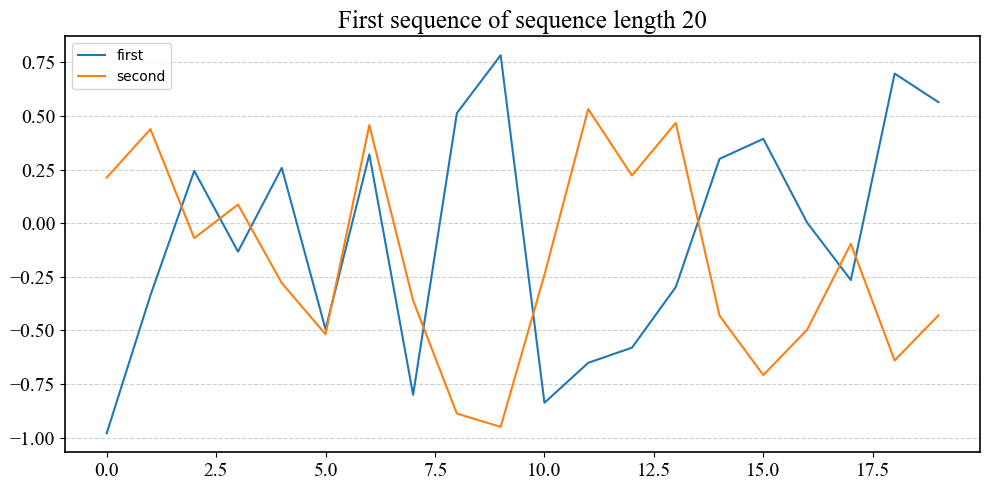

In [14]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sequences[0, :, 0], label='first')
ax.plot(sequences[0, :, 1], label='second')
plot_style.apply_grid(ax)
ax.set_title(f"First sequence of sequence length {seq_len}")
plot_style.apply_plot_style(ax)
ax.legend()
plt.show()

## Split the Dataset into Train/Test
We split the sequences into training and testing sets, with 20% of the data reserved for testing. To ensure reproducibility, we use the `random_state=ENV_CONFIG["random_state"]` parameter.

In [15]:
train_data, test_data = train_test_split(
    sequences,
    test_size=0.2,
    random_state=ENV_CONFIG["random_state"])

In [16]:
train_data.shape

(2700, 20, 2)

In [17]:
test_data.shape

(675, 20, 2)

## Setting Up the Training Dataloader

We will create a DataLoader using PyTorch's built-in implementation to handle batching.

In [18]:
from torch.utils.data import DataLoader

In [19]:
train_dl = DataLoader(train_data, batch_size=DATA_CONFIG["batch_size"], shuffle=True)

In [20]:
# Number of batches
len(train_dl)

169

In [21]:
# Fetch a single batch from the DataLoader
batch = next(iter(train_dl))
# batch size time series of length sequence_len!
batch.shape

torch.Size([16, 20, 2])

## TimeVAE: A Flexible VAE for Time Series Generation 


[TimeVAE](https://arxiv.org/abs/2111.08095) is a Variational Autoencoder for time series generation, introduced by Desai et al. (2021). It builds upon the standard VAE framework, similar to those used in image generation, but with specialized encoder and decoder architectures designed to better capture temporal structures, such as trends and seasonal components, directly within the modeling process.

This approach combines the flexibility and interpretability of traditional methods like Dynamic Linear Models (DLMs) with the ability to capture non-linear relationships in high-dimensional data.

In the paper, the authors present two architectures:

- Base TimeVAE, which does not incorporate domain knowledge, and
- Interpretable TimeVAE, which allows domain knowledge to be injected and is tailored to model specific time series components.

In this notebook, we describe and implement the Interpretable TimeVAE architecture, as it is the more elaborate of the two.

### Architecture of Interpretable TimeVAE 

1. TimeVAE Encoder:
- The encoder processes the input time series through a series of convolutional layers with ReLU activation.

- The output of the encoder is flattened and passed through a fully connected (dense) linear layer to determine the parameters of the distribution over the latent variable, which is modeled as a multivariate Gaussian. 

- A realization of the latent variable is sampled using the reparametrization trick, which is then feed into the decoder.

A schematic representation of Base TimeVAE Encoder can be found in the figure below (adapted from Figure 1 in Desai et al. (2021)). In this illustration, the input $X$  is processed through a series of operations, including convolutional layers, reshaping, and a dense layer, to determine the parameters of the latent variable distribution $Z$. The Base decoder takes a realization of $Z$ and tries to reconstruct the input by inverting the encoding process

![](./../../assets/figures/chapter06/timevae-paper-figure-1.png)


2. TimeVAE Decoders

As mentioned, we may use specialized decoders to model different patterns in the time series, each of which takes the latent variable as input. The outputs of these decoders are combined in parallel—by addition—to produce the final reconstruction of the time series. A schematic representation of the Interpretable TimeVAE architecture can be found in below, which is adapted from Figure 2 in Desai et al. (2021).


![](./../../assets/figures/chapter06/timevae-paper-figure-2.png)

The figure above illustrates the main components in Interpretable TimeVAE. Specialized decoders, such as the **Trend Block**, **Seasonal Block 1**, and **Seasonal Block 2**, take the latent variable $Z$ as input. The outputs of these decoders are combined in parallel through addition to produce the final reconstruction of the time series. Seasonal Block 1 and Seasonal Block 2 can represent different seasonal components, capturing multiple seasonalities present in the time series

A few more details can be found in Chapter 6 of the book,  while more specific details are provided in the paper. [TimeVAE: A Variational Auto-Encoder for Multivariate Time Series Generation](https://arxiv.org/abs/2111.08095).


If you are not yet familiar with the standard VAE implementation, we recommend starting with the VAE notebook, where the encoder and decoder architectures are easier to follow.

### TimeVAE implementation

As already mentioned,  TimeVAE  builds upon the standard VAEs framework, but with specialized  encoder and decoder. 

In this implementation:
- We reuse the VAEModule and GaussSampler components from the image generation example in the VAE notebook.
- We design new encoder and decoder modules specifically optimized for modeling time series.


#### Encoder and Decoder Networks

##### Encoder
The encoder takes a time series input of shape `[sequence_len, n_feat]` and applies a stack of 1D convolutional layers to extract temporal patterns. It outputs the mean and log variance vectors, parameterizing a latent distribution.

The network is similar to the `CNN` encoder we used for the image generation example but operates in 1D since we are dealing with time series.

##### Decoder

The decoder reconstructs the time series from a sampled latent vector $z$. It does this by independently modeling four key components of a time series, each with a specialized decoder:


1. Level
2. Trend
3. Seasonality
4. Residuals

Each component is modeled by its own neural subnetwork (decoder, or blocks). If we denote the mapping of a specific decoder $d$ as a fuction of $z$,  then in this experiment we have:

1. $d_l(z)$ – level
2. $d_t(z)$ – trend
3. $d_s(z)$ – seasonality
4. $d_r(z)$ – residuals


The reconstructed time series is the sum of all components:

$$
\hat{x} =  d_l(z)+ d_t(z)+ d_s(z)+ d_r(z)
$$


In [22]:
import torch
import torch.nn as nn
from typing import Tuple, List


class TrendLayer(nn.Module):
    """
    Models polynomial trends in time series data.
    
    This layer learns polynomial coefficients for each feature dimension and applies them
    to generate trend patterns in the time series.
    
    Args:
        seq_len (int): Length of the time series sequence
        feat_dim (int): Number of features/dimensions in the time series
        latent_dim (int): Dimension of the latent space
        trend_poly (int): Degree of the polynomial trend to model
    """
    def __init__(
        self,
        seq_len: int,
        feat_dim: int,
        latent_dim: int,
        trend_poly: int
        ):
        super(TrendLayer, self).__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.latent_dim = latent_dim
        self.trend_poly = trend_poly

        self.trend_encoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.feat_dim * self.trend_poly),
            nn.ReLU(),
            nn.Linear(self.feat_dim * self.trend_poly, self.feat_dim * self.trend_poly)

        )

    def forward(
        self,
        z: torch.Tensor) -> torch.Tensor:
        trend_params: torch.Tensor = self.trend_encoder(z)
        trend_params = trend_params.view(-1, self.feat_dim, self.trend_poly)

        lin_space: torch.Tensor = torch.arange(0, float(self.seq_len), 1, device=z.device) / self.seq_len 
        poly_space: torch.Tensor = torch.stack([lin_space ** float(p + 1) for p in range(self.trend_poly)], dim=0) 
        
        trend: torch.Tensor = trend_params @ poly_space 
        trend: torch.Tensor = trend.transpose(2, 1) 
        return trend


class SeasonalLayer(nn.Module):
    """
    Models seasonal patterns in time series data.
    
    This layer can handle multiple seasonal patterns with different periods and lengths.
    Each seasonal pattern is learned independently and combined additively.
    
    Args:
        seq_len (int): Length of the time series sequence
        feat_dim (int): Number of features/dimensions in the time series
        latent_dim (int): Dimension of the latent space
        custom_seas (List[Tuple[int, int]]): List of (num_seasons, len_per_season) tuples
            specifying the seasonal patterns to model
    """
    def __init__(
        self,
        seq_len: int,
        feat_dim: int,
        latent_dim: int,
        custom_seas: List[Tuple[int, int]]):
        super(SeasonalLayer, self).__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.custom_seas = custom_seas

        self.input_proj_layers = nn.ModuleList([
            nn.Linear(latent_dim, feat_dim * num_seasons)
            for num_seasons, _ in custom_seas
        ])

    def _get_season_indexes_over_seq(self, num_seasons: int, len_per_season: int):
        season_indexes = torch.arange(num_seasons).unsqueeze(1) + torch.zeros(
            (num_seasons, len_per_season), dtype=torch.int32
        )
        season_indexes = season_indexes.view(-1)
        season_indexes = season_indexes.repeat(self.seq_len // len_per_season + 1)[: self.seq_len]
        return season_indexes


    def forward(
        self,
        z: torch.Tensor) -> torch.Tensor:
        N = z.size(0)
        ones_tensor = torch.ones((N, self.feat_dim, self.seq_len), dtype=torch.int32, device=z.device)

        all_seas_vals = []
        for i, (num_seasons, len_per_season) in enumerate(self.custom_seas):
            season_params: torch.Tensor = self.input_proj_layers[i](z)
            season_params = season_params.view(-1, self.feat_dim, num_seasons)

            season_indexes_over_time: torch.Tensor = self._get_season_indexes_over_seq(
                num_seasons, len_per_season
            ).to(z.device)

            dim2_idxes: torch.Tensor = ones_tensor * season_indexes_over_time.view(1, 1, -1)
            season_vals: torch.Tensor = torch.gather(season_params, 2, dim2_idxes)
            all_seas_vals.append(season_vals)

        all_seas_vals: torch.Tensor = torch.stack(all_seas_vals, dim=-1) 
        all_seas_vals: torch.Tensor  = torch.sum(all_seas_vals, dim=-1)  
        all_seas_vals: torch.Tensor = all_seas_vals.transpose(2, 1)  
        return all_seas_vals


class LevelModel(nn.Module):
    """
    Models the base level of the time series.
    
    This layer learns a constant level for each feature dimension that persists
    throughout the entire sequence.
    
    Args:
        latent_dim (int): Dimension of the latent space
        feat_dim (int): Number of features/dimensions in the time series
        seq_len (int): Length of the time series sequence
    """
    def __init__(self,
        latent_dim: int,
        feat_dim: int,
        seq_len: int):
        super(LevelModel, self).__init__()
        self.latent_dim = latent_dim
        self.feat_dim = feat_dim
        self.seq_len = seq_len
        self.level_encoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.feat_dim),
            nn.ReLU(),
            nn.Linear(self.feat_dim, self.feat_dim)

        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        # (bs, feat_dim)
        level_params: torch.Tensor = self.level_encoder(z)

        level_params: torch.Tensor = level_params.view(-1, 1, self.feat_dim)
        ones_tensor = torch.ones((1, self.seq_len, 1), dtype=torch.float32, device=z.device)

        level_vals: torch.Tensor = level_params * ones_tensor
        return level_vals


class ResidualConnection(nn.Module):
    """
    Models non-linear patterns and noise in the time series.
    
    This layer uses a convolutional decoder architecture to capture complex,
    non-linear patterns that cannot be explained by trend or seasonality.
    
    Args:
        seq_len (int): Length of the time series sequence
        feat_dim (int): Number of features/dimensions in the time series
        hidden_layer_sizes (List[int]): List of hidden layer sizes for the decoder
        latent_dim (int): Dimension of the latent space
        encoder_last_dense_dim (int): Dimension of the encoder's last dense layer
    """
    def __init__(self, seq_len, feat_dim, hidden_layer_sizes, latent_dim, encoder_last_dense_dim):
        super(ResidualConnection, self).__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.input_proj = nn.Linear(latent_dim, encoder_last_dense_dim)

        self.input_channels = hidden_layer_sizes[-1]
        self.input_dim = encoder_last_dense_dim//self.input_channels

        decoder_channels = [*hidden_layer_sizes[::-1], feat_dim]

        n_layers = len(hidden_layer_sizes)
        output_sequence_len = self.input_dim * (2 ** n_layers)
        final = nn.Linear(
            output_sequence_len * feat_dim,
            seq_len * feat_dim
            )

        decoder_layers = []
        for i in range(len(decoder_channels) - 1):
            convt = nn.ConvTranspose1d(
                decoder_channels[i],
                decoder_channels[i+1],
                kernel_size=3, stride=2, padding=1, output_padding=1)
            decoder_layers.append(convt)
            decoder_layers.append(nn.ReLU())
        self.decoder = nn.Sequential(*decoder_layers, nn.Flatten(), final)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x: torch.Tensor = self.input_proj(z)
        x: torch.Tensor = x.view(-1, self.input_channels, self.input_dim)
        x: torch.Tensor  = self.decoder(x)
        return x.view(-1, self.seq_len, self.feat_dim)

    

class TimeVAEEncoder(nn.Module):
    """
    Encodes time series data into a latent space representation.
    
    Uses a convolutional architecture to compress the time series into a lower-dimensional
    latent space, outputting both mean and log variance of the latent distribution.
    
    Args:
        seq_len (int): Length of the time series sequence
        feat_dim (int): Number of features/dimensions in the time series
        hidden_layer_sizes (List[int]): List of hidden layer sizes for the encoder
        latent_dim (int): Dimension of the latent space
    """
    def __init__(
            self,
            seq_len: int,
            feat_dim: int,
            hidden_layer_sizes: int,
            latent_dim: int):
        super(TimeVAEEncoder, self).__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.latent_dim = latent_dim
        encoder_layers = []

        filter_dims = [feat_dim, *hidden_layer_sizes]

        for i in range(len(filter_dims) - 1):
            conv_layer = nn.Conv1d(filter_dims[i], filter_dims[i + 1], kernel_size=3, stride=2, padding=1)
            encoder_layers.append(conv_layer)
            encoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Flatten())
        self.encoder = nn.Sequential(*encoder_layers)
        self.encoder_last_dense_dim = self._get_last_dense_dim(seq_len, feat_dim)
        self.z_mean = nn.Linear(self.encoder_last_dense_dim, latent_dim)
        self.z_log_var = nn.Linear(self.encoder_last_dense_dim, latent_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x: torch.Tensor = x.transpose(1, 2)
        x: torch.Tensor = self.encoder(x)
        z_mean: torch.Tensor = self.z_mean(x)
        z_log_var: torch.Tensor = self.z_log_var(x)
        return z_mean, z_log_var
    
    def _get_last_dense_dim(self, seq_len: int, feat_dim: int) -> int:
        with torch.no_grad():
            x = torch.randn(1, feat_dim, seq_len)
            x: torch.Tensor = self.encoder(x)
            return x.numel()


class TimeVAEDecoder(nn.Module):
    """
    Decodes latent space representations back into time series data.
    
    Combines multiple components (trend, seasonality, level, and residuals) to reconstruct
    the original time series from its latent representation.
    
    Args:
        seq_len (int): Length of the time series sequence
        feat_dim (int): Number of features/dimensions in the time series
        hidden_layer_sizes (List[int]): List of hidden layer sizes for the decoder
        latent_dim (int): Dimension of the latent space
        encoder_last_dense_dim (int): Dimension of the encoder's last dense layer
        trend_poly (int, optional): Degree of polynomial trend to model. Defaults to 0
        custom_seas (List[Tuple[int, int]], optional): List of (num_seasons, len_per_season)
            tuples specifying seasonal patterns. Defaults to None
        use_residual_conn (bool, optional): Whether to use residual connections.
            Defaults to True
    """
    def __init__(
            self,
            seq_len: int,
            feat_dim: int,
            hidden_layer_sizes: List[int],
            latent_dim: int,
            encoder_last_dense_dim: int,
            trend_poly: int = 0,
            custom_seas: List[Tuple[int, int]]=None,
            use_residual_conn: bool = True
        ):
        super(TimeVAEDecoder, self).__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.latent_dim = latent_dim
        self.trend_poly = trend_poly
        self.custom_seas = custom_seas
        self.use_residual_conn = use_residual_conn
        self.encoder_last_dense_dim = encoder_last_dense_dim
        self.level_model = LevelModel(self.latent_dim, self.feat_dim, self.seq_len)

        if use_residual_conn:
            self.residual_conn = ResidualConnection(seq_len, feat_dim, hidden_layer_sizes, latent_dim, encoder_last_dense_dim)
        
        if self.trend_poly is not None and self.trend_poly > 0:
            self.trend_layer = TrendLayer(self.seq_len, self.feat_dim, self.latent_dim, self.trend_poly)

        if self.custom_seas is not None and len(self.custom_seas) > 0:
            self.seasonal_layer = SeasonalLayer(self.seq_len, self.feat_dim, self.latent_dim, self.custom_seas)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        outputs: torch.Tensor = self.level_model(z)
        if self.trend_poly is not None and self.trend_poly > 0:
            trend: torch.Tensor = self.trend_layer(z)
            outputs += trend

        if self.custom_seas is not None and len(self.custom_seas) > 0:
            seasonality: torch.Tensor = self.seasonal_layer(z)
            outputs += seasonality

        if self.use_residual_conn:
            residuals: torch.Tensor = self.residual_conn(z)
            outputs += residuals

        return outputs



In [23]:
# Import the main VAE module and Gaussian sampler for training the variational autoencoder
from genai4t.chapters.vae import VAEModule, GaussSampler

In [24]:
# Define model configuration parameters for training TimeVAE
MODEL_CONFIG = {
    'latent_dim': 8, # Dimensionality of the latent space
    'hidden_layer_sizes': [50, 100, 200], # Sizes of hidden layers in encoder/decoder 
    'use_residual_conn': True, # Whether to use residual connections
    'trend_poly': 0,  # Degree of polynomial used for trend modeling (0 = none)
    'custom_seas': None,  # Optionally provide custom seasonality functions
    'reconstruction_wt': 3., # Weight of the reconstruction loss in total loss
    'lr': 0.001, # Learning rate
    "steps": 169 * 100, # Number of training steps
    "model_dir": './artifacts/TimeVAE' # Directory to save trained model artifacts    
}

In [25]:
# Initialize the TimeVAE encoder with model configuration
encoder = TimeVAEEncoder(
    seq_len=seq_len,
    feat_dim=feat_dim,
    hidden_layer_sizes=MODEL_CONFIG["hidden_layer_sizes"],
    latent_dim=MODEL_CONFIG["latent_dim"])

encoder

TimeVAEEncoder(
  (encoder): Sequential(
    (0): Conv1d(2, 50, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(50, 100, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(100, 200, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=600, out_features=8, bias=True)
  (z_log_var): Linear(in_features=600, out_features=8, bias=True)
)

In [26]:
# Instantiate the TimeVAE decoder with model configuration
decoder = TimeVAEDecoder(
    seq_len=seq_len,
    feat_dim=feat_dim,
    hidden_layer_sizes=MODEL_CONFIG["hidden_layer_sizes"],
    latent_dim=MODEL_CONFIG["latent_dim"],
    trend_poly=MODEL_CONFIG["trend_poly"],
    custom_seas=MODEL_CONFIG["custom_seas"],
    use_residual_conn=MODEL_CONFIG["use_residual_conn"],
    encoder_last_dense_dim=encoder.encoder_last_dense_dim)
decoder

TimeVAEDecoder(
  (level_model): LevelModel(
    (level_encoder): Sequential(
      (0): Linear(in_features=8, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=2, bias=True)
    )
  )
  (residual_conn): ResidualConnection(
    (input_proj): Linear(in_features=8, out_features=600, bias=True)
    (decoder): Sequential(
      (0): ConvTranspose1d(200, 100, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
      (1): ReLU()
      (2): ConvTranspose1d(100, 50, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
      (3): ReLU()
      (4): ConvTranspose1d(50, 2, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=48, out_features=40, bias=True)
    )
  )
)

In [27]:
# Instantiate the full VAE model with encoder, decoder, and Gaussian latent sampler
vae = VAEModule(
    encoder,
    decoder,
    sampler=GaussSampler(),
    reconstruction_wt=MODEL_CONFIG["reconstruction_wt"],
    lr=MODEL_CONFIG["lr"])

In [28]:
# Import utility functions for model training and weight initialization
from genai4t.model.utils import fit_model, init_linear_weights

In [29]:
# Apply custom weight initialization to the VAE model
vae = vae.apply(init_linear_weights)

In [30]:
# Set the VAE model to training mode
vae.train()

VAEModule(
  (encoder): TimeVAEEncoder(
    (encoder): Sequential(
      (0): Conv1d(2, 50, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(50, 100, kernel_size=(3,), stride=(2,), padding=(1,))
      (3): ReLU()
      (4): Conv1d(100, 200, kernel_size=(3,), stride=(2,), padding=(1,))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (z_mean): Linear(in_features=600, out_features=8, bias=True)
    (z_log_var): Linear(in_features=600, out_features=8, bias=True)
  )
  (decoder): TimeVAEDecoder(
    (level_model): LevelModel(
      (level_encoder): Sequential(
        (0): Linear(in_features=8, out_features=2, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2, out_features=2, bias=True)
      )
    )
    (residual_conn): ResidualConnection(
      (input_proj): Linear(in_features=8, out_features=600, bias=True)
      (decoder): Sequential(
        (0): ConvTranspose1d(200, 100, kernel_size=(3,), stride=(2,), padding=(1,),

##  Train

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | encoder | TimeVAEEncoder | 85.3 K | train
1 | decoder | TimeVAEDecoder | 82.8 K | train
---------------------------------------------------
168 K     Trainable params
0         Non-trainable params
168 K     Total params
0.672     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


total_n_params: 168102


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=16900` reached.


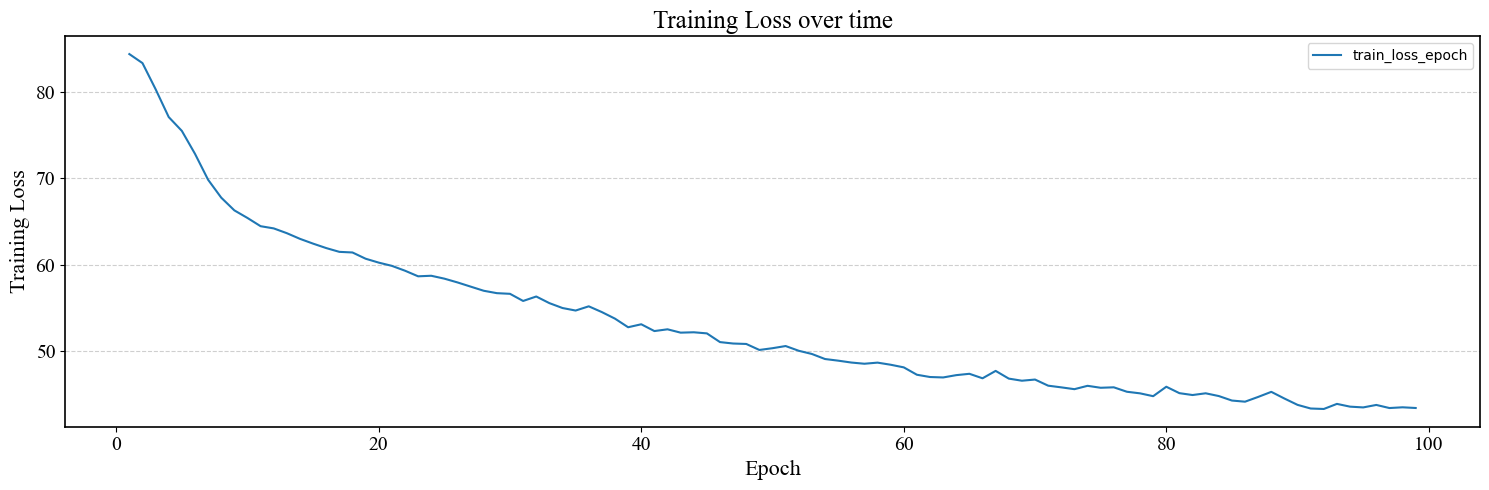

In [31]:
## Train the VAE model
fit_model(
    MODEL_CONFIG["model_dir"],
    vae,
    train_dl,
    num_steps=MODEL_CONFIG['steps'],
    plot=True,
    random_state=ENV_CONFIG["random_state"])

## Unconditional Generation

in this section, we will sample latent vectors directly from a standard normal distribution $\mathcal{N}(\mathbf{0}, I)$ and use the decoder to produce new time series

In [32]:
# Set the model to evaluation mode
vae.eval()

VAEModule(
  (encoder): TimeVAEEncoder(
    (encoder): Sequential(
      (0): Conv1d(2, 50, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(50, 100, kernel_size=(3,), stride=(2,), padding=(1,))
      (3): ReLU()
      (4): Conv1d(100, 200, kernel_size=(3,), stride=(2,), padding=(1,))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (z_mean): Linear(in_features=600, out_features=8, bias=True)
    (z_log_var): Linear(in_features=600, out_features=8, bias=True)
  )
  (decoder): TimeVAEDecoder(
    (level_model): LevelModel(
      (level_encoder): Sequential(
        (0): Linear(in_features=8, out_features=2, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2, out_features=2, bias=True)
      )
    )
    (residual_conn): ResidualConnection(
      (input_proj): Linear(in_features=8, out_features=600, bias=True)
      (decoder): Sequential(
        (0): ConvTranspose1d(200, 100, kernel_size=(3,), stride=(2,), padding=(1,),

In [33]:
# Move the model to the appropriate device (CPU or GPU)
vae.to(device)

VAEModule(
  (encoder): TimeVAEEncoder(
    (encoder): Sequential(
      (0): Conv1d(2, 50, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(50, 100, kernel_size=(3,), stride=(2,), padding=(1,))
      (3): ReLU()
      (4): Conv1d(100, 200, kernel_size=(3,), stride=(2,), padding=(1,))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (z_mean): Linear(in_features=600, out_features=8, bias=True)
    (z_log_var): Linear(in_features=600, out_features=8, bias=True)
  )
  (decoder): TimeVAEDecoder(
    (level_model): LevelModel(
      (level_encoder): Sequential(
        (0): Linear(in_features=8, out_features=2, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2, out_features=2, bias=True)
      )
    )
    (residual_conn): ResidualConnection(
      (input_proj): Linear(in_features=8, out_features=600, bias=True)
      (decoder): Sequential(
        (0): ConvTranspose1d(200, 100, kernel_size=(3,), stride=(2,), padding=(1,),

In [34]:
# Set the random seed for reproducibility
set_random_state(ENV_CONFIG["random_state"])

# Define the number of samples to generate
num_samples = len(test_data) * DATA_CONFIG["num_eval_iterations"]

# Sample latent vectors from a standard normal distribution
z = torch.randn(num_samples, MODEL_CONFIG["latent_dim"]).to(device)


with torch.no_grad():
    # Decode the latent vectors to generate synthetic time series
    synthetic_data = vae.decoder(z)
    # Move the generated data back to CPU and convert to NumPy
    synthetic_data = synthetic_data.cpu().numpy()
# Reshape the synthetic data to match the shape of the test data
synthetic_data_iters = synthetic_data.reshape(-1, *test_data.shape)

Seed set to 2024


## Evaluation

Now that we've generated synthetic data, it's time to evaluate its performance.

We'll use the metrics described in the `EvaluationGenerativeModels.ipynb` notebook, so feel free to check it out if any of the metrics seem unfamiliar.

Note that the `synthetic_data_iters` array has the shape `(num_eval_iterations, test_size, sequence_len, n_feat)`. This is because we calculate the **discriminator scores** and **predictive scores** across `num_eval_iterations`. Since we generate data by sampling from the latent space, each iteration may yield different scores. Running multiple iterations helps ensure more reliable and robust scores.

In [35]:
from genai4t.evaluation.generation.visualize import (
    visualize_2d_pca,
    visualize_2d_tsne,
    visualize_time_series)
from genai4t.evaluation.generation.bp import evaluate

In [36]:
# take the first iteration and use it to compute visual metrics
first_synthetic_data = synthetic_data_iters[0]

### Visualization
Let's visualize real versus synthetic time series

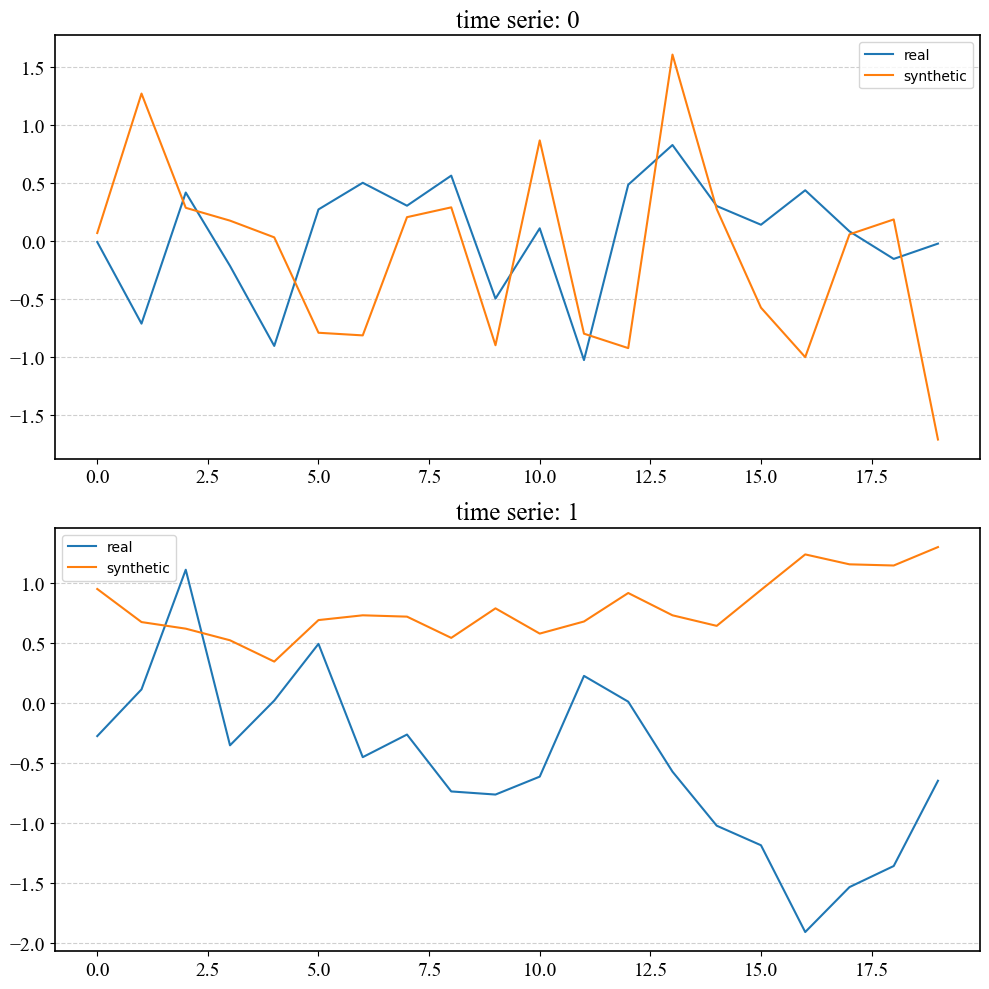

In [37]:
for i in np.random.choice(len(test_data), size=1):
    visualize_time_series(test_data[i], first_synthetic_data[i])

### Diversity

Do the generated samples cover the distribution of the real data?


To answer this question, we apply t-SNE or PCA to both the original and synthetic datasets (after flattening the temporal dimension). Here we project the data into 2-dimensional space, allowing us to visually assess how closely the distribution of the generated samples resembles that of the real data.

In [38]:
# get the first time series
test_single_series = test_data[..., 0]
synthetic_single_series = first_synthetic_data[..., 0]

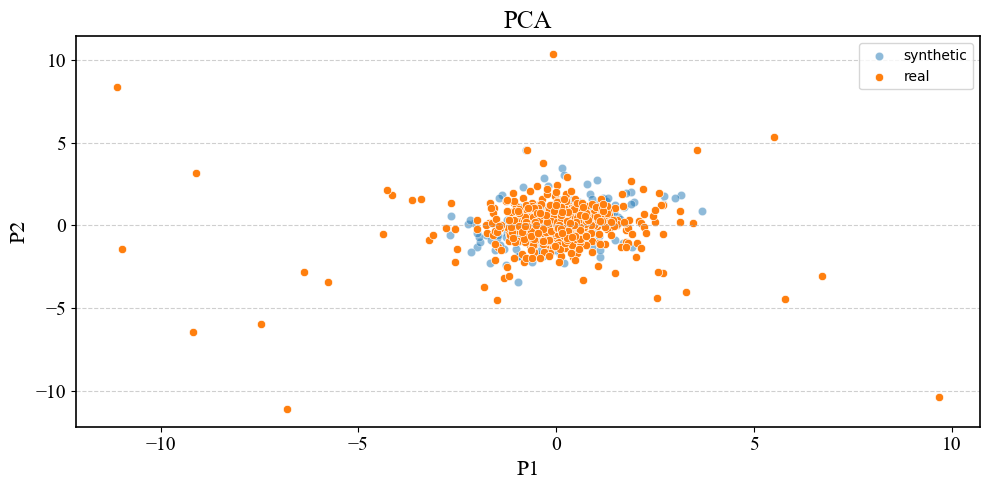

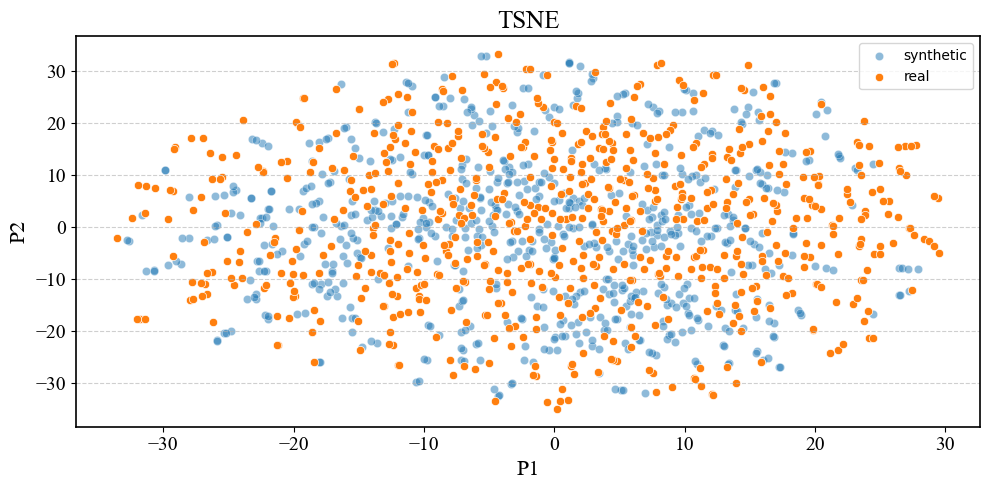

In [39]:
# Visualization of 2D PCA projection
visualize_2d_pca(test_single_series, synthetic_single_series)
# Visualization of 2D TSNE projection
visualize_2d_tsne(test_single_series, synthetic_single_series)

### Discriminative and Predictive Scores

- The **discriminative score** evaluates how well a classifier can distinguish real data from synthetic data by measuring metrics like accuracy.
  
- The **predictive score** measures how useful synthetic data is for forecasting tasks by training a model to predict the next value and comparing its performance to a model trained on real data.

For simplicity, we use a single-layer `LSTM` based architecture for both the classifier and the regressor, without any architecture search or hyperparameter tuning. More details can be found in the `EvaluationGenerativeModels.ipynb` notebook.

Below, we provide both scores

In [40]:
# compute scores
predictive_scores, discrimnative_scores = evaluate(
    test_data,
    synthetic_data_iters,
    random_state=ENV_CONFIG["random_state"],
    max_iters=DATA_CONFIG["num_eval_iterations"])

  0%|          | 0/50 [00:00<?, ?it/s]

Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpyo_7__1g..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpm9u0r4yi..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj2sxa41y..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpeo4mvmw1..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpr8_9vtqg..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxrm4wlj0..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpuwx4sq80..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5ta6uv74..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpmxqbvnad..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp4x7qck3a..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2j69r6fh..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplh6p_tc6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxvg5w25y..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpdjs7m6ma..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpke1ieyl6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp9hs3p4_e..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp10k8iw0a..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmphtsu00iu..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp430gygym..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp_nyrt6k0..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp9xt1igg6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpi8pok814..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmprfxgaahx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpixhnzumg..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpre3l106k..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj0obejc1..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp6eb43kys..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpyky9v0fz..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp44tty5uo..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp9thjglny..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpt2vliwaw..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3wtvubld..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpa8lgyy_o..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpqgusil32..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpvu6_2_uw..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpytg5yp0h..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpjx53typp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpr6hrajl2..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5f55vyu6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8golurqk..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpccgcsnrd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5nwihyxk..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpzya58x_p..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpos6fnyls..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxba39781..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpm37svkzu..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp7vlmy2en..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpjqibcfn5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplre1tkxt..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpoksif3tf..


`Trainer.fit` stopped: `max_steps=1000` reached.


  0%|          | 0/50 [00:00<?, ?it/s]

Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottle

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpr1sdn9sz..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmphnmxspex..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpznx60oig..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmph8cqhrot..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp96eyxsk2..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnlby_ece..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5ey56kxx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpg4m_zfh_..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8ky1_zs5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpokd_ppq4..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpmr_bn7q0..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpaos_t6y6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmprzkmbixv..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp1xu5xbpb..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxem8eyav..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp45l1uitj..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpv71a80k3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp9_fe_pa9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnjp2_x07..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp_ee639nu..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmphly8vn3s..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpoyfiy87c..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnaa1dsk8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp07v9k7mh..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpc5ie_jup..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmparf0yd2r..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpv7o2oc83..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpytqjwb6l..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpcrrxf42p..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmptgh60m1y..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpy7yyjk_0..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp7lui43w9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj_z65x6w..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2xyyjywp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxojkoxxd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpb5uyvs4z..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpdcgiux49..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpcwj_57aw..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxi8a6ek5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpi_jyj2ud..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp35c_pfee..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp69w8y_xc..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp21ue7egz..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3a_d3xy4..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpl_xp2ndd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmprj0uyt1i..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0q0frj5s..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp4p4bviqn..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpau_jzn26..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpendw8fsu..


`Trainer.fit` stopped: `max_steps=1000` reached.


In [41]:
# Display the discriminative scores 
discrimnative_scores

,count,mean,std,min,25%,50%,75%,max
auc,50.0,0.968303,0.007509,0.943210,0.965501,0.968532,0.972263,0.987709
precision,50.0,0.898864,0.024599,0.841060,0.880697,0.899640,0.915110,0.953846
recall,50.0,0.918815,0.022841,0.859259,0.903704,0.925926,0.933333,0.955556
f1,50.0,0.908287,0.012527,0.884892,0.899813,0.909099,0.916364,0.935849
acc,50.0,0.907185,0.013034,0.881481,0.900000,0.907407,0.914815,0.937037


In [42]:
# Display the predictive scores 
predictive_scores

,count,mean,std,min,25%,50%,75%,max
MSE,50.0,0.873237,0.055409,0.729062,0.832432,0.885540,0.904410,0.974788
MAE,50.0,0.617153,0.012466,0.583412,0.610257,0.617224,0.623596,0.654278
MAPE,50.0,336.082989,43.085842,225.197148,302.267873,335.794175,364.724541,423.996830
